In [1]:
import numpy as np
import h5py, math
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.ion()


In [2]:
# functions
def fit_non_linear(tlitlist):
    (mm,nn) = tlitlist.shape
    non_linearity = np.zeros(mm)
    for i in range(mm):
        tlit = tlitlist[i]
        (bincount, bins) = np.histogram(tlit,bins=50)
        tlb = bins[np.argwhere(bincount>=2)[0,0]]
        tub = bins[np.argwhere(bincount>=2)[-1,0]+1]
        tpulse = tub-tlb
        nbins = int(tpulse*10)+1
        (I_t, time) = np.histogram(tlit,bins=nbins)
        I_t = I_t/I_t.sum()
        non_linearity[i] = np.sum(I_t**2)
    return non_linearity

def read_data(Tmodel, njob, tpulse_list):
    dirname = '../2.Trend_t/{}/'.format(Tmodel)
    # holders
    tlist = []; contlist = []; tpulselist = []
    for i, tpulse in enumerate(tpulse_list):
        fname = dirname + '{}atom_{}fs_{}_{}nm.h5'.format(
            Natom,tpulse,Tmodel,round(dsamp*1e9,2))
        with h5py.File(fname,'r') as f:
            for numjob in range(njob):
                tlit = f['{}/source'.format(numjob)][3]
                contrast = f['{}/contrast'.format(numjob)][0]
                # fit for real pulse duration
                (bincount, bins) = np.histogram(tlit, bins=50)
                tlb = bins[np.argwhere(bincount>=2)[0,0]]
                tub = bins[np.argwhere(bincount>=2)[-1,0]+1]
                tlist.append(tub-tlb)
                contlist.append(contrast)
                tpulselist.append(tpulse)
    tlist = np.asarray(tlist)
    contlist = np.asarray(contlist)
    tpulselist = np.asarray(tpulselist)
    return tlist, contlist, tpulselist

def fit_data(tlist, contlist, binedges):
    taxis, terr, cont, cerr = ([] for i in range(4))
    for i in range(binedges.size-1):
        index = np.argwhere((tlist>=binedges[i])&(tlist<binedges[i+1]))
        if index.size == 0: continue
        tt = np.ravel(tlist[index])
        cc = np.ravel(contlist[index])
        taxis.append(tt.mean())
        terr.append(np.sqrt(np.cov(tt, aweights=1/tt)))
        cont.append(cc.mean())
        cerr.append(np.sqrt(np.cov(cc, aweights=1/cc)))
    taxis = np.asarray(taxis)
    terr = np.asarray(terr)
    cont = np.asarray(cont)
    cerr = np.asarray(cerr)
    return taxis, terr, cont, cerr
    

In [3]:
# data params
njob = 36
tpulsemin = 0.
tpulsemax = 48.
tpulse_list = np.arange(0,48)*1.
Natom = 1000
dsamp = 10. * 1e-9
Tmodels = ['Square','Gaus','SASE']
labels = ['Square', 'Gaussian', 'SASE']
colors = ['sandybrown','grey','mediumseagreen']


In [4]:
# read data - image
fnames = [
    '1C_0.1fs_Gaus_speckle.h5',
    '3C_0.1fs_Gaus_speckle.h5',
    '3C_10.0fs_Gaus_speckle.h5',
    '3C_100.0fs_Gaus_speckle.h5']

imgs = []
contrasts = []

for fname in fnames:
    with h5py.File(fname, 'r') as f:
        imgs.append(f['image'][:])
        contrasts.append(f['contrast'][0])


In [5]:
# read data - trend
taxii, terrs, conts, cerrs = ([] for i in range(4))
binedges = np.linspace(tpulsemin,tpulsemax,2*int(tpulsemax-tpulsemin)+1)
for Tmodel in Tmodels:
    tlist, contlist, tpulselist = read_data(Tmodel, njob, tpulse_list)
    taxis, terr, cont, cerr = fit_data(tpulselist, contlist, binedges)
    taxii.append(taxis); terrs.append(terr)
    conts.append(cont); cerrs.append(cerr)

C:\Users\nanw0\AppData\Local\Temp/ipykernel_10676/895089474.py:48: RuntimeWarning: divide by zero encountered in true_divide
  terr.append(np.sqrt(np.cov(tt, aweights=1/tt)))
C:\Users\nanw0\anaconda3\lib\site-packages\numpy\lib\function_base.py:412: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
C:\Users\nanw0\anaconda3\lib\site-packages\numpy\lib\function_base.py:2529: RuntimeWarning: invalid value encountered in double_scalars
  fact = w_sum - ddof*sum(w*aweights)/w_sum


In [12]:
def add_subplot_axes(ax,rect):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

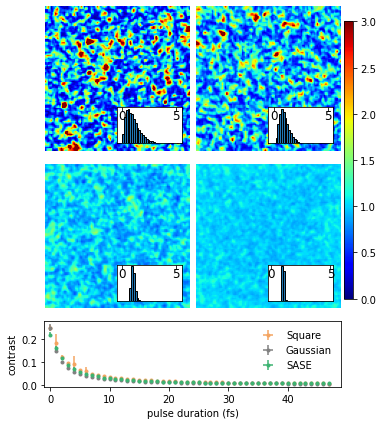

In [111]:
# plot
fig = plt.figure(figsize=(6,7))
gs = fig.add_gridspec(5,9)
ax1 = fig.add_subplot(gs[0:2, 0:4])
ax2 = fig.add_subplot(gs[0:2, 4:8])
ax3 = fig.add_subplot(gs[2:4, 0:4])
ax4 = fig.add_subplot(gs[2:4, 4:8])
ax5 = fig.add_subplot(gs[4,0:-1])

# fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.3, 0.02, 0.55])
# fig.tight_layout()

rect = [0.5, 0.05, 0.45, 0.25]
bins = np.linspace(0,5,31)

# images
im = ax1.imshow(imgs[0], vmin=0, vmax=3, cmap='jet'); ax1.axis('off')
ax1i = add_subplot_axes(ax1,rect)
ax1i.hist(np.ravel(imgs[0]),bins=bins,edgecolor='k')
ax1i.set_xlim([-.5,5.5]); ax1i.xaxis.set_ticks_position('top')
ax1i.tick_params(axis='x',direction='in',pad=-15);ax1i.axes.set_xticks([0,5])
plt.yticks([]); plt.xticks(fontsize=12)

ax2.imshow(imgs[1], vmin=0, vmax=3, cmap='jet'); ax2.axis('off')
ax2i = add_subplot_axes(ax2,rect)
ax2i.hist(np.ravel(imgs[1]),bins=bins,edgecolor='k')
ax2i.set_xlim([-.5,5.5]); ax2i.xaxis.set_ticks_position('top')
ax2i.tick_params(axis='x',direction='in',pad=-15);ax2i.axes.set_xticks([0,5])
plt.yticks([]); plt.xticks(fontsize=12)

ax3.imshow(imgs[2], vmin=0, vmax=3, cmap='jet'); ax3.axis('off')
ax3i = add_subplot_axes(ax3,rect)
ax3i.hist(np.ravel(imgs[2]),bins=bins,edgecolor='k')
ax3i.set_xlim([-.5,5.5]); ax3i.xaxis.set_ticks_position('top')
ax3i.tick_params(axis='x',direction='in',pad=-15);ax3i.axes.set_xticks([0,5])
plt.yticks([]); plt.xticks(fontsize=12)

ax4.imshow(imgs[3], vmin=0, vmax=3, cmap='jet'); ax4.axis('off')
ax4i = add_subplot_axes(ax4,rect)
ax4i.hist(np.ravel(imgs[3]),bins=bins,edgecolor='k')
ax4i.set_xlim([-.5,5.5]); ax4i.xaxis.set_ticks_position('top')
ax4i.tick_params(axis='x',direction='in',pad=-15);ax4i.axes.set_xticks([0,5])
plt.yticks([]); plt.xticks(fontsize=12)

# colorbar
fig.colorbar(im, cax=cbar_ax)

# contrast vs pulse duration
for i, Tmodel in enumerate(Tmodels):
    if not Tmodel.endswith('mono'):
        ax5.errorbar(taxii[i], conts[i], yerr=cerrs[i], xerr=terrs[i],
                     label=labels[i], fmt='.', color=colors[i])

# set plot style      
ax5.legend(frameon=False)
ax5.set_xlabel('pulse duration (fs)')
ax5.set_ylabel('contrast')
ax5.set_xlim([-1,49])
plt.axis('tight')
plt.savefig('Figure_2_pattern_and_histogram_and_trend.eps')